In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!mkdir data
!tar -xvzf cifar-10-python.tar.gz -C data
!rm cifar-10-python.tar.gz

--2020-06-06 06:05:51--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  89.8MB/s    in 1.8s    

2020-06-06 06:05:53 (89.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
!curl https://raw.githubusercontent.com/snatch59/load-cifar-10/master/load_cifar_10_alt.py > load_cifar.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3493  100  3493    0     0  20547      0 --:--:-- --:--:-- --:--:-- 20547


In [0]:
from load_cifar import load_data
import numpy as np
from skimage.transform import resize
import torchvision.models as models
import torch
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
cifar_10_dir = 'data/cifar-10-batches-py'
(x_train, y_train), (x_test, y_test) = load_data(cifar_10_dir)

In [0]:
data_size = 1000
x_train = x_train[:data_size]
y_train = y_train[:data_size].reshape((data_size))
del x_test
del y_test

In [0]:
def to_one_hot(x, num_classes):
    b = np.zeros((len(x), num_classes), dtype=np.double)
    b[np.arange(len(x)), x] = 1
    return b

In [0]:
y_train = to_one_hot(y_train, 10)

In [0]:
resized_x = []
for i in range(data_size):
    resized_x.append(resize(x_train[i], (224, 224)))
x_train = torch.tensor(resized_x).reshape((-1, 3, 224, 224)).double()
x_train.shape
del resized_x
y_train = torch.tensor(y_train).to(device)

In [10]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [11]:
vgg.classifier[6] = torch.nn.Linear(4096, 10)
vgg = vgg.double().to(device)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
optimizer = torch.optim.Adam(list(vgg.classifier[6].parameters()) + list(vgg.classifier[3].parameters()))

In [0]:
epochs = 1
batch_size = 50
for epoch in range(epochs):

    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_train[start_index:end_index].to(device)

        optimizer.zero_grad()
        
        y_hat = torch.nn.functional.softmax(vgg(x_batch))
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y_batch)

        loss.backward()
        optimizer.step()

        print(loss.data.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0.29338289364851405
0.31126173390733936
0.3047731883393954
0.30200878776439866
0.29980691910324203
0.30553320172445325
0.314605043029092
0.3027086440903571
0.3050252051338912
0.3011175879758762
0.3238541073813584
0.3089265395232722
0.3239780969463415
0.3195895876396177
0.3093475328016304
0.3008906910902244


tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([[0.0965, 0.1910, 0.0796, 0.1295, 0.0582, 0.0369, 0.1470, 0.0900, 0.1041,
         0.0673],
        [0.0377, 0.1108, 0.1722, 0.1222, 0.0230, 0.0955, 0.2349, 0.0471, 0.0615,
         0.0950]], device='cuda:0', dtype=torch.float64)


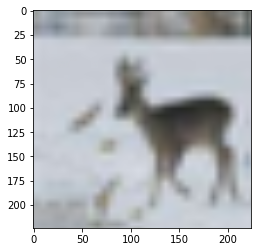

In [30]:
with torch.no_grad():
  index = 20
  x_test = x_train[index: index+2].to(device)
  y_test = y_train[index: index+2]
  plt.imshow(x_test[0].to('cpu').reshape(224, 224, 3))
  print(y_test)

  y_hat = torch.nn.functional.softmax(vgg(x_test))
  
  print(y_hat)